In [1]:
import numpy as np
import pickle

with open('cache/traintest.pkl', 'rb') as f:
    df_train, df_test, train_y = pickle.load(f)
    
with open('cache/traintest_decomposition2_50.pkl', 'rb') as f:
    out50_train, out50_test = pickle.load(f)
        
with open('cache/non_zero_stats.pkl', 'rb') as f:
    agg_train, agg_test = pickle.load(f)        

In [2]:
from sklearn.feature_selection import VarianceThreshold    
import pandas as pd
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
import xgboost as xgb


In [3]:
df_train.shape, out50_train.shape, agg_train.shape

((4459, 4735), (4459, 100), (4459, 18))

In [4]:
def _to_ignore(df_train):
    def low_variance(df_train):
        s = VarianceThreshold(threshold=.0)
        s.fit(df_train)
        idxs = s.get_support()
        to_remove = [c for c, x in zip(df_train.columns, idxs) if not x]
        return to_remove

    def nunique(df_train):
        _, index = np.unique(df_train.values, return_index=True, axis=1)
        return [c for idx, c in enumerate(df_train.columns) if idx not in index]

    def suspicious(df_train):
        # drop zero fraction
        thr = 0.98
        to_ignore = []
        for column in df_train.columns:
            counts = df_train[column].value_counts()
            value_fraction = counts[0] / len(df_train)
            if value_fraction >= thr:
                to_ignore.append(column)
        return to_ignore

    to_ignore = set()
    to_ignore |= set(low_variance(df_train))
    to_ignore |= set(nunique(df_train))
    to_ignore |= set(suspicious(df_train))
    return to_ignore

from sklearn.feature_selection import VarianceThreshold    
from sklearn import preprocessing, model_selection, metrics

to_ignore = _to_ignore(df_train)
features = [c for c in df_train if c not in to_ignore]

In [5]:
print(len(features))

2121


In [6]:
original = [
    'f190486d6',
    '58e056e12',
    '58e2e02e6',
    '15ace8c9f',
    'fc436be29',
    '9fd594eec',
    'b6fa5a5fd',
    'eeb9cd3aa',
]

In [7]:
for c in original:
    print(c, np.max(df_train[c]), np.max(df_test[c]))

f190486d6 319612000.0 200000000.0
58e056e12 319612000.0 343333340.0
58e2e02e6 319612000.0 343333340.0
15ace8c9f 319612000.0 270074900.0
fc436be29 130000000.0 174891420.0
9fd594eec 115538000.0 343333340.0
b6fa5a5fd 200000000.0 279597950.0
eeb9cd3aa 319612000.0 336784540.0


In [8]:
import scipy
from tqdm import tqdm

In [9]:
def build_stats(df_train, df_test, columns):
    out_train = pd.DataFrame()
    out_test = pd.DataFrame()
    
    df_all = pd.concat([df_train[columns], df_test[columns]]).astype(np.float32)
    
    for c in tqdm(columns):
        _, _, bin_idx = scipy.stats.binned_statistic(df_all[c], df_all[c], bins=100)
        out_train[f"{c}_bin"] = bin_idx[:df_train.shape[0]]
        out_test[f"{c}_bin"] = bin_idx[df_train.shape[0]:]
        
        rank = scipy.stats.rankdata(df_all[c])
        out_train[f"{c}_rank"] = rank[:df_train.shape[0]]
        out_test[f"{c}_rank"] = rank[df_train.shape[0]:]
        
        #no good
        #zscore = scipy.stats.rankdata(df_all[c])
        #out_train[f"{c}_zscore"] = zscore[:df_train.shape[0]]
        #out_test[f"{c}_zscore"] = zscore[df_train.shape[0]:]
        
    return out_train, out_test
     
        
    

In [10]:
stats1_train, stats1_test = build_stats(df_train, df_test, original)

100%|██████████| 8/8 [00:00<00:00, 61.84it/s]


In [29]:
train_X = pd.concat([df_train[original], out50_train, agg_train, stats1_train], axis=1)
#train_X = pd.concat([df_train[features], out50_train, agg_train, stats1_train], axis=1)
#train_X = pd.concat([out50_train, agg_train], axis=1)
train_X = train_X.replace([np.inf, -np.inf], np.nan)
train_X = train_X.fillna(0)

test_X = pd.concat([df_test[original], out50_test, agg_test, stats1_test], axis=1)
#test_X = pd.concat([df_test[features], out50_test, agg_test, stats1_test], axis=1)
#test_X = pd.concat([out50_test, agg_test], axis=1)
test_X = test_X.replace([np.inf, -np.inf], np.nan)
test_X = test_X.fillna(0)


In [30]:
train_X.shape, test_X.shape

((4459, 142), (49342, 142))

In [31]:
# need to scale & normalize everything
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

for c in tqdm(train_X.columns):
    s = MinMaxScaler()
    s.fit(train_X[c].values.reshape(-1, 1))
    train_X[c] = s.transform(train_X[c].values.reshape(-1, 1))
    test_X[c] = s.transform(test_X[c].values.reshape(-1, 1))
    
    

 55%|█████▍    | 78/142 [00:00<00:00, 772.32it/s]/opt/miniconda2/envs/avito/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
100%|██████████| 142/142 [00:00<00:00, 732.98it/s]


In [34]:

def run_cv2(train_X, train_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 127,
        "max_depth": -1,
        "learning_rate" : 0.005,
        #'min_child_weight': 10,
        #'reg_lambda': 0.1,
        #'subsample': 0.5,
        #'scale_pos_weight': 1,
        #'reg_alpha': 0.0,
        #'colsample_bytree': 0.5,
        #'max_bin': 255,
        # 'subsample_freq': 4,
        #'min_child_samples': 1,
                
        #'min_data_in_leaf': 100,
        "feature_fraction" : 0.15,
        "bagging_fraction" : 0.2,
        "bagging_frequency" : 1,
        #"bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, 
                          label=train_y)
    hist = lgb.cv(params, 
                  lgtrain, 
                  10000, 
                  nfold=5, 
                  early_stopping_rounds=100, 
                  stratified=False,
                  verbose_eval=50)


In [35]:
run_cv2(train_X, train_y)
print('.')

[50]	cv_agg's rmse: 1.62298 + 0.0327949
[100]	cv_agg's rmse: 1.53156 + 0.027106
[150]	cv_agg's rmse: 1.46915 + 0.0230909
[200]	cv_agg's rmse: 1.4255 + 0.0198853
[250]	cv_agg's rmse: 1.39529 + 0.0178088
[300]	cv_agg's rmse: 1.37523 + 0.0166195
[350]	cv_agg's rmse: 1.36146 + 0.0153628
[400]	cv_agg's rmse: 1.35226 + 0.0151321
[450]	cv_agg's rmse: 1.34566 + 0.0151192
[500]	cv_agg's rmse: 1.34159 + 0.01524
[550]	cv_agg's rmse: 1.33871 + 0.0153881
[600]	cv_agg's rmse: 1.33685 + 0.0152656
[650]	cv_agg's rmse: 1.33555 + 0.0152996
[700]	cv_agg's rmse: 1.33454 + 0.0154284
[750]	cv_agg's rmse: 1.33392 + 0.0156588
[800]	cv_agg's rmse: 1.3337 + 0.0154994
[850]	cv_agg's rmse: 1.3333 + 0.0154556
[900]	cv_agg's rmse: 1.33326 + 0.0154014
[950]	cv_agg's rmse: 1.33306 + 0.0153441
[1000]	cv_agg's rmse: 1.33314 + 0.0154218
[1050]	cv_agg's rmse: 1.33331 + 0.0153683
.


In [149]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 127,
        "max_depth": -1,
        "learning_rate" : 0.005,
        #'min_child_weight': 10,
        #'reg_lambda': 0.1,
        #'subsample': 0.5,
        #'scale_pos_weight': 1,
        #'reg_alpha': 0.0,
        #'colsample_bytree': 0.5,
        #'max_bin': 255,
        # 'subsample_freq': 4,
        #'min_child_samples': 1,
                
        #'min_data_in_leaf': 100,
        "feature_fraction" : 0.15,
        "bagging_fraction" : 0.2,
        "bagging_frequency" : 1,
        #"bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, 
                      lgtrain, 
                      num_boost_round=10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=200, 
                      evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [150]:
                  
folds = 3
kf = model_selection.KFold(n_splits=folds, shuffle=True, random_state=0)

sub_preds = np.zeros(test_X.shape[0])
oof_preds = np.zeros(train_X.shape[0])

for fold_no, (dev_index, val_index) in enumerate(kf.split(train_X)):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    
    oof_preds[val_index] = model.predict(val_X, num_iteration=model.best_iteration)
    fold_rmse = np.sqrt(metrics.mean_squared_error(val_y, oof_preds[val_index]))
    print(f"fold {fold_no}: ", fold_rmse)    
    
    pred_test = model.predict(test_X, num_iteration=model.best_iteration)    
    sub_preds += np.expm1(pred_test) / folds
    #
    #
    break

Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.34076	valid_1's rmse: 1.4546
[400]	training's rmse: 1.17141	valid_1's rmse: 1.36794
[600]	training's rmse: 1.07563	valid_1's rmse: 1.34406
[800]	training's rmse: 1.00797	valid_1's rmse: 1.33578
[1000]	training's rmse: 0.957817	valid_1's rmse: 1.33251
[1200]	training's rmse: 0.916205	valid_1's rmse: 1.33109
[1400]	training's rmse: 0.876063	valid_1's rmse: 1.33081
Early stopping, best iteration is:
[1318]	training's rmse: 0.89235	valid_1's rmse: 1.33061
fold 0:  1.3306080441518056


In [151]:
#1.333

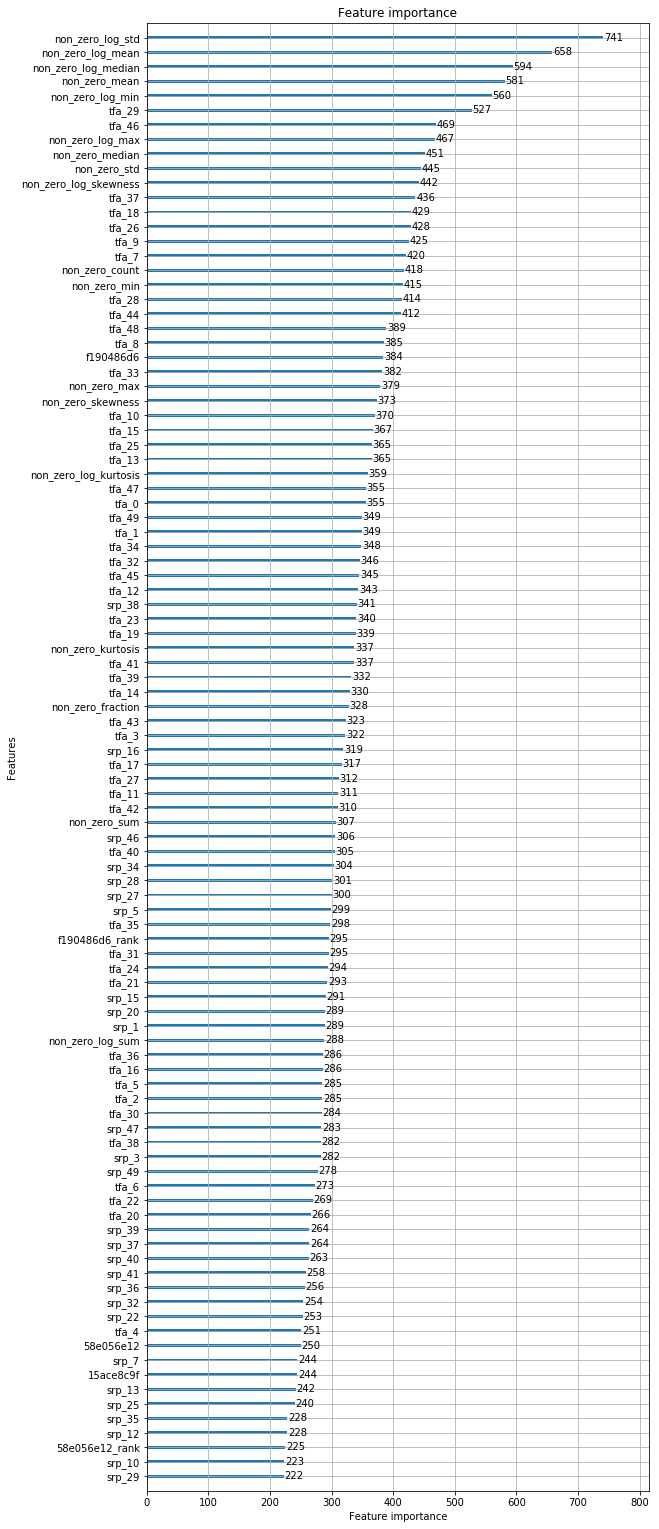

In [152]:
lgb.plot_importance(model, max_num_features=100, figsize=(9, 27))    

In [17]:
sample = pd.read_csv('input/test.csv', usecols=['ID'])
sample["target"] = sub_preds
sample.to_csv("submissions/subm_20180629_lgb2.csv", index=False)

In [41]:
train_X.shape, train_y.shape, test_X.shape

((4459, 142), (4459,), (49342, 142))

In [36]:
import tensorflow as tf

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


In [37]:
tf.__version__

'1.8.0'

In [115]:
import keras
import random

class MyGenerator(keras.utils.Sequence):
    def __init__(self, df, df_y=None, batch_size=32, shuffle=True):        
        self.X = df
        self.y = df_y
        self.batch_size = batch_size
        self.shuffle =shuffle
        self.idxs = None
        self.on_epoch_end()        
        
    def __len__(self):
        # number of batches per epoch
        return int(np.floor(self.X.shape[0] / self.batch_size))
    
    def __getitem__(self, idx):
        # generate one batch
        batch_x = self.X.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
    def on_epoch_end(self):
        self.idxs = np.arange(self.X.shape[0])
        if self.shuffle:
            np.random.shuffle(self.idxs)
            

In [129]:
from keras.layers import Input, Dense, Lambda, Dropout, BatchNormalization
from keras.models import Model
from keras import backend as K
from sklearn.metrics import mean_squared_error as mse

    
def nn1(input_dim):
    inputs = Input(shape=(input_dim, ))
    x = Dense(512, activation='relu')(inputs)
    x = Dense(512, activation='relu')(x)        
    x = Dense(1)(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

folds = 10
kf = model_selection.KFold(n_splits=folds, shuffle=True, random_state=0)

#sub_preds = np.zeros(test_X.shape[0])
oof_preds = np.zeros(train_X.shape[0])

for fold_no, (dev_index, val_index) in enumerate(kf.split(train_X)):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    train_g = MyGenerator(dev_X, dev_y)
    val_g = MyGenerator(val_X, val_y)
    
    ckpt = ModelCheckpoint(filepath='cache/20180629.hdf5', verbose=0, save_best_only=True)
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    model = nn1(train_X.shape[1])
    model.fit(dev_X, dev_y, 
              validation_data=(val_X, val_y),
              callbacks=[ckpt],
              epochs=100)
    
    #model.fit_generator(generator=train_g,
    #                    validation_data=val_g,
    #                    callbacks=[ckpt, reduce_lr],
    #                    epochs=100)

    #model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    #model = load_model('cache/20180629.hdf5')
    
    fold_preds = model.predict(val_X, verbose=1).ravel()
    fold_rmse = np.sqrt(mse(val_y, fold_preds))
    print(f"fold {fold_no}: ", fold_rmse)    
    
    fold_train_preds = model.predict(dev_X, verbose=1).ravel()
    fold_train_rmse = np.sqrt(mse(dev_y, fold_train_preds))
    print(f"fold {fold_no}: ", fold_train_rmse)    
        
    oof_preds[val_index] = fold_preds
    
    #pred_test = model.predict(test_X, num_iteration=model.best_iteration)    
    #sub_preds += np.expm1(pred_test) / folds
    #
    #
    break

Train on 4013 samples, validate on 446 samples
Epoch 1/100
4013/4013 [==============================] - 2s 409us/step - loss: 7.4874 - val_loss: 2.6542
Epoch 2/100
4013/4013 [==============================] - 0s 78us/step - loss: 3.8004 - val_loss: 2.1643
Epoch 3/100
4013/4013 [==============================] - 0s 77us/step - loss: 3.5269 - val_loss: 8.3367
Epoch 4/100
4013/4013 [==============================] - 0s 77us/step - loss: 3.2056 - val_loss: 7.1785
Epoch 5/100
4013/4013 [==============================] - 0s 77us/step - loss: 2.9691 - val_loss: 3.7013
Epoch 6/100
4013/4013 [==============================] - 0s 77us/step - loss: 2.9709 - val_loss: 3.7032
Epoch 7/100
4013/4013 [==============================] - 0s 77us/step - loss: 2.8153 - val_loss: 2.4106
Epoch 8/100
4013/4013 [==============================] - 0s 77us/step - loss: 2.7135 - val_loss: 2.1101
Epoch 9/100
4013/4013 [==============================] - 0s 77us/step - loss: 2.5978 - val_loss: 4.7397
Epoch 10/100
401